# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from math import tan, atan2, pi, inf
from collections import deque
from itertools import islice
from random import randrange
from statistics import mean, median
from math import sqrt
%matplotlib inline
print()

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


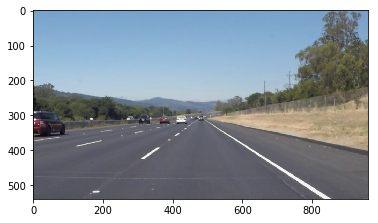

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

# Helper Function Constants

In [3]:
#Canny Parameters
CANNY_HIGH = 150
CANNY_LOW = 50

#Gaussian Parameters
GAUSSIAN_KERNEL = 3

#Region of Interest Insets (as percentages of image width and height)
#Describes a quadralateral
ROI_TOP_LEFT = 0.45 #0.47
ROI_TOP_RIGHT = 0.45 #0.47
ROI_BOTTOM_LEFT = 0.0 #0.05
ROI_BOTTOM_RIGHT = 0.0 #0.05
ROI_TOP = 0.60
ROI_BOTTOM = 0.0

#Hough
HOUGH_RHO = 2
HOUGH_THETA = np.pi/(1*180)
HOUGH_THRESHOLD = 15
HOUGH_MIN_LEN = 35 #25
HOUGH_MAX_GAP = 35

#Slope
THETA_POS_THRESHOLD = 0.5
THETA_NEG_THRESHOLD = 0.5

#ExtendLine
REGION_INSIDE = 0 #0b0000
REGION_LEFT = 1   #0b0001
REGION_RIGHT = 2  #0b0010
REGION_TOP = 4    #0b0100
REGION_BOTTOM = 8 #0b1000

#History
HIST_LEFT = 0
HIST_RIGHT = 1

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [210]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def roi_vertices(img, topLeft=0.0, topRight=0.0, bottomLeft=0.0, bottomRight=0.0,top=0.0, bottom=0.0):
    """
    Computes the vertices of a quadralateral based on left, right, top and bottom insets
    specified as percentages of the image's width (for left and right insets)
    and height(for top and bottom insets)"""
    height = img.shape[0]
    width = img.shape[1]
    verts = np.array([[
        (width * bottomLeft, height * (1 - bottom)),
        (width * topLeft, height * top),
        (width * (1 - topRight), height * top),
        (width * (1 - bottomRight), height * (1 - bottom)),
         ]], np.int32)
    return verts

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns a list of found lines, and an image with those lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]),
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return  lines, line_img

def theta(line):
    """
    Slope of a line as a polar coordinate theta.  The line should be a list of
    four integers representing two cartesian coordinates of the line's endpoints.
    """
    return atan2(line[0][3] - line[0][1], line[0][2] - line[0][0])

def weightedAverage(items):
    """
    Compute the weighted average for a list of numbers where the weight of each item is the inverse
    of it's distance from the median.
    """
    if len(items) == 0:
        return 0
    
    totalWeights = 0
    weightedSum = 0
    avg = median(items)

    for i in items:
        if i == avg:
            w = 100
        else:
            w = 1 / abs(i - avg)
        totalWeights += w
        weightedSum += w * i
        
    return weightedSum / totalWeights

def thetaMedian(items):
    if len(items) == 1:
        result = items[0]
    else:
        items.sort()
        result = items[int(len(items)/2)]
    return result

def thetaAverage(items, algo="Median"):
    """
    Wrapper for specific averaging algorithms.
    """
    if algo == "Median":
        return thetaMedian(items)
    elif algo == "WeightedAverage":
        return weightedAverage(items)
    
    
def genLine(lines, thetas, avgTheta, minY=0, maxY=inf, minX=0, maxX=inf):
    """
    Find the best line in lines with slope closest to avgTheta and extrapolate a new line
    bounded by the rectangle [minX, minY, maxX, maxY].  The new line contains the midpoint
    of the best line. If maxY and/or maxX are inf, then replace them with the maximum Y or X,
    respectively, from lines. Typical uses of minY, maxY, minX, maxX would be to specify either
    the size of an image, or the bounds of a region of interest.
    
    Returns the new line.
    """
    
    idxNearestTheta = 0
    distNearestTheta = inf
    
    for i in range(len(thetas)):
        dist = avgTheta - thetas[i]
        if dist < distNearestTheta:
            distNearestTheta = dist
            idxNearestTheta = i
            
    line = lines[idxNearestTheta]
    midPt = ((line[0][2] + line[0][0]) / 2, (line[0][3] + line[0][1]) / 2)
    tanTheta = tan(avgTheta)
    
    if maxX == inf:
        maxX = max([max(y[1], y[3]) for y in lines])
        
    if maxY == inf:
        maxY = max([max(x[0], x[2]) for x in lines])
        
    # find vertical distance from midpoint to max Y and min Y
    hi_dY = maxY - midPt[1]
    lo_dY = midPt[1] - minY
    
    # find X coordinate corresponding to min Y and max Y
    if tanTheta == 0:
        hi_X = lo_X = midPt[0]
    else:
        hi_X = int(midPt[0] + round(hi_dY / tanTheta))
        lo_X = int(midPt[0] - round(lo_dY / tanTheta))
    
    return [[lo_X, minY, hi_X, maxY]]

def line_len(line):
    return sqrt((line[0][2] - line[0][0]) ** 2 + (line[0][3] - line[0][1]) ** 2)

def genLine1(lines, thetas, avgTheta, minY=0, maxY=inf, minX=0, maxX=inf):
    """
    Generate a single line clipped by a region.
    """
    
    # If there is more than one line, choose the line which is most representative
    # of the set
    if len(lines) < 1:
        return lines
    elif len(lines) == 1:
        line = lines[0]
    else:
        #Choose the longest line
        lengths = [line_len(x) for x in lines]
        longest_len = max(lenghts)
    
    # Generate a single line with a slope whose endpoints lie on the edge of a
    # region pramaterized by minY, maxY, minX, maxX
    
    
    
    
def averageLines(lines, thetas, minY, maxY, minX, maxX):
    """
    Returns a new line and theta based on the average theta of lines.
    """

    avgTheta = thetaAverage(thetas, algo="WeightedAverage")  #or can use algo="Median"
    line = genLine(lines, thetas, avgTheta, minY=minY, maxY=maxY, minX=minX, maxX=maxX)
    
    return line, avgTheta

def longestLine(lines):
    """
    Find the longest line in lines.  In case of ties, any of the longest lines
    may be returned.
    
    Return the longest line and it's theta.
    """
    longestLine = None
    longestLen = 0
    lengths = []
    
    for l in lines:
        lineLen = line_len(l)
        lengths.append(lineLen)
        if lineLen > longestLen:
            longestLen = lineLen
            longestLine = l
            
    lineLengths = zip(lines, lengths)
    #print("longestLine(): inspected ", len(lines), " lines." )
    #print("  longest: ", longestLine, " length: ", longestLen, " theta: ", theta(longestLine))
    #for i in lineLengths:
        #print("   ", i)
    return longestLine, theta(longestLine)


def matchEndPoints(lines, direction='Y'):
    """
    Given a sequence of lines and a direction ('X' or 'Y'), find the line(s) having
    an end point at the maximum or minimum location in the specified direction.  If
    the two endpoints belong to different lines, create a new line defined by the
    two endpoints.
    
    Return the new line and the parent line(s) of the
    two endpoints.
    
    Future improvements include using NumPy arrays to extract the min and max endpoints
    from lines without so many for loops.  Also, the smallest possible coordinate is assumed
    to be zero.  This makes sense for images, but perhaps negative coordinates would make
    this function more general.
    """
    if direction == 'Y':
        coords = [0, 2]
    else:
        coords = [1, 3]
        
    minC = inf
    maxC = 0
        
    minL = [inf, inf, inf, inf]
    maxL = [0, 0, 0, 0]
    
    for l in lines:
        for coord in coords:
            if l[coord] < minL[coord]: minL, minC = l, coord
            if l[coord] > maxL[coord]: maxL, maxC = l, coord
                
    if minLine == maxLine: newLine, parents = minLine, [minLine]
    else:
        if direction == "Y":
            newLine = [minL[minC - 1], minL[minC], maxL[maxC - 1], maxL[maxC]]
        else:
            newLine = [minL[minC], minL[minC + 1], maxL[maxC], maxL[maxC + 1]]
        parents = [minL, maxL]
        
    return [newLine], parents

def regionCode(x, y, minY, maxY, minX, maxX): 
    code = REGION_INSIDE 
    if x < minX:      # to the left of rectangle 
        code |= REGION_LEFT 
    elif x > maxX:    # to the right of rectangle 
        code |= REGION_RIGHT 
    if y < minY:      # below the rectangle 
        code |= REGION_BOTTOM 
    elif y > maxY:    # above the rectangle 
        code |= REGION_TOP 
  
    return code

def boundaryCode(line, minY, maxY, minX, maxX):
    x1, y1, x2, y2 = line[0][0], line[0][1], line[0][2], line[0][3]
    codeP1, codeP2 = 0, 0 
    
    if x1 == minX:      # left edge of rectangle 
        codeP1 |= REGION_LEFT 
    elif x1 == maxX:    # right edge of rectangle 
        codeP1 |= REGION_RIGHT 
    if y1 == minY:      # bottom edge of rectangle 
        codeP1 |= REGION_BOTTOM 
    elif y1 == maxY:    # top edge of rectangle 
        codeP1 |= REGION_TOP 
  
    if x2 == minX:      # left edge of rectangle 
        codeP2 |= REGION_LEFT 
    elif x2 == maxX:    # right edge of rectangle 
        codeP2 |= REGION_RIGHT 
    if y2 == minY:      # bottom edge of rectangle 
        codeP2 |= REGION_BOTTOM 
    elif y2 == maxY:    # top edge of rectangle 
        codeP2 |= REGION_TOP 
  
    return codeP1, codeP2

def orientationCode(line):
    x1, y1, x2, y2 = line[0][0], line[0][1], line[0][2], line[0][3]
    codeP1, codeP2 = 0, 0
    if x1 < x2:
        codeP1 |= REGION_LEFT
        codeP2 |= REGION_RIGHT
    elif x1 > x2: 
        codeP1 |= REGION_RIGHT
        codeP2 |= REGION_LEFT
    else: #vertical line -- do not add any left/rigth code
        pass
    if y1 < y2:
        codeP1 |= REGION_BOTTOM
        codeP2 |= REGION_TOP
    elif y1 > y2: 
        codeP1 |= REGION_TOP
        codeP2 |= REGION_BOTTOM
    else: #horizontal line -- do not add any top/bottom code
        pass

    return codeP1, codeP2

def cohenSutherlandClip(line, minY, maxY, minX, maxX):
    """
    Adapted from https://www.geeksforgeeks.org/line-clipping-set-1-cohen-sutherland-algorithm/
    """
  
    x1, y1, x2, y2 = line[0][0], line[0][1], line[0][2], line[0][3]
    
    # Compute region codes for line
    code1 = regionCode(x1, y1, minY, maxY, minX, maxX) 
    code2 = regionCode(x2, y2, minY, maxY, minX, maxX) 
    finished = False
    accept = False
  
    while not finished: 
  
        # If both endpoints lie within rectangle 
        if code1 == 0 and code2 == 0: 
            accept = True
            finished = True
  
        # If both endpoints are outside rectangle 
        elif (code1 & code2) != 0: 
            finished = True
  
        # Some segment lies within the rectangle 
        else: 
  
            # Line Needs clipping 
            # At least one of the points is outside,  
            # select it 
            x, y = 1.0, 1.0
            dx, dy = x2 - x1, y2 - y1
            code_out = code1 if code1 != 0 else code2
  
            # Find intersection point using
            # y = y1 + slope * (x - x1),  
            # x = x1 + (1 / slope) * (y - y1) 
            if code_out & REGION_TOP: 
                # point is above the clip rectangle 
                x = x1 if dy == 0 else x1 + dx * (maxY - y1) / dy 
                y = maxY 
  
            elif code_out & REGION_BOTTOM: 
                # point is below the clip rectangle 
                x = x1 if dy == 0 else x1 + dx * (minY - y1) / dy 
                y = minY 
  
            elif code_out & REGION_RIGHT: 
                # point is to the right of the clip rectangle 
                y = y1 if dx == 0 else y1 + dy * (maxX - x1) / dx 
                x = maxX 
  
            elif code_out & REGION_LEFT: 
                # point is to the left of the clip rectangle 
                y = y1 if dx == 0 else y1 + dy * (minX - x1) / dx
                x = minX 
  
            # Now intersection point x,y is found 
            # We replace point outside clipping rectangle 
            # by intersection point 
            if code_out == code1: 
                x1 = int(x) 
                y1 = int(y) 
                code1 = regionCode(x1, y1, minY, maxY, minX, maxX) 
  
            else: 
                x2 = int(x) 
                y2 = int(y) 
                code2 = regionCode(x2, y2, minY, maxY, minX, maxX) 
        
    return [[x1,y1,x2,y2]] if accept else None

def extendLine(line, minY, maxY, minX, maxX):
    """
    Given a line and a bounding rectangle, scale and clip the line to form a new line
    whose endpoints lie on the bounding rectangle. Return None if no scalar muptilpe of
    the line would intersect the bounding rectangle.
    """
    #print("extendLine(): ", line[0][0], line[0][1], line[0][2], line[0][3], " is line before clipping")
    clippedLine = cohenSutherlandClip(line, minY, maxY, minX, maxX)
    if clippedLine == None: #no portion of line is within bounding rectangle
        return None
    
    x1, y1, x2, y2 = clippedLine[0][0], clippedLine[0][1], clippedLine[0][2], clippedLine[0][3]
    #print("extendLine(): ", x1, y1, x2, y2, " is line after clipping")
    
    # Compute orientation codes for line
    orientationCode1, orientationCode2 = orientationCode(clippedLine)
    #print("extendLine(): orientations: ", orientationCode1, orientationCode2)
 
    finished = False
  
    while not finished: 
        # Compute boundary codes for line.  Assuming cohenSutherlandClip() was previously run on
        # the data, no points in clippedLine will lie outside of the bounding rectangle, the 
        # only possibilities are that each endpoint lies inside of the bounding rectangle,
        # or it lies exactly on the bounding rectangle.
        boundaryCode1, boundaryCode2 = boundaryCode([[x1, y1, x2, y2]], minY, maxY, minX, maxX)
        
        # If both endpoints lie on the boundary 
        if boundaryCode1 != 0 and boundaryCode2 != 0: 
            finished = True
  
        else: # Some endpoint still lies within the rectangle's interior
            # Line Needs to be extended 
            dx, dy = abs(x2 - x1), abs(y2 - y1)
            code = orientationCode1 if boundaryCode1 == 0 else orientationCode2
            if boundaryCode1 == 0:
                x, y = x1, y1 
            else:
                x, y = x2, y2
  
            # Find intersection point using
            # y = y1 + slope * (x - x1),  
            # x = x1 + (1 / slope) * (y - y1) 
            if code & REGION_TOP:
                topGap = maxY - y
                xTrans = topGap * dx / dy
                if code & REGION_LEFT:
                    leftGap = x - minX
                    yTrans = leftGap * dy / dx
                    if topGap <= leftGap: #line will intersect with top bound
                        x -= xTrans
                        y = maxY
                    else: #line will intersect with left bound
                        y += yTrans
                        x = minX
                elif code & REGION_RIGHT:
                    rightGap = maxX - x
                    yTrans = rightGap * dy / dx
                    if topGap <= rightGap: #line will intersect with top bound
                        x += xTrans
                        y = maxY
                    else: #line will intersect with right bound
                        y += yTrans
                        x = maxX
                else: #vertical line
                    #x stays the same
                    y = maxY     
            elif code & REGION_BOTTOM:
                bottomGap = y - minY
                xTrans = bottomGap * dx / dy
                if code & REGION_LEFT:
                    leftGap = x - minX
                    yTrans = leftGap * dy / dx
                    if bottomGap <= leftGap: #line will intersect with bottom bound
                        x -= xTrans
                        y = minY
                    else: #line will intersect with left bound
                        y -= yTrans
                        x = minX
                elif code & REGION_RIGHT:
                    rightGap = maxX - x
                    yTrans = rightGap * dy / dx
                    if bottomGap <= rightGap: #line will intersect with bottom bound
                        x += xTrans
                        y = minY
                    else: #line will intersect with right bound
                        y -= yTrans
                        x = maxX
                else: #vertical line
                    #x stays the same
                    y = minY
            else: #horizontal line
                #y stays the same
                if code & REGION_LEFT:
                    x = minX
                elif code & REGION_RIGHT:
                    x = maxX
                else:
                    print("Shouldn't have gotten here!!  OrientationCode has no directions attached.")
                 
            # Replace the point inside bounding rectangle 
            # with x, y
            if boundaryCode1 == 0:
                x1, y1 = int(x), int(y) 
            else:
                x2, y2 = int(x), int(y)  
        
    l = [[x1,y1,x2,y2]]
    
    return l, theta(l)
    
        
def sloped_lines(lines, min_theta_pos=0.7, min_theta_neg=0.7, average=False,
                 minY=0, maxY=inf, minX=0, maxX=inf, findEndPoints=False,
                 useLongest=False):
    """
    'lines' should be a list of lines in the format returned by cv2.hough().
    
    Returns two lists of lines -- one for positively sloped lines, and one for negatively sloped ones.
    The absolute value of the slope must be greater than min_theta_pos and min_theta_neg, respectively.
    
    If average is True, then one positive line and one negative line are generated based on the weighted
    average of the slopes of all qualified lines.  These average lines are generated using maxY and 
    minY to extrapolate line lengths.  MaxY = inf indicates that the maximum Y should be the maximum Y
    value of any line in lines.
    """
    
    pos_lines, neg_lines = [], []
    pos_theta, neg_theta = [], []
    
    for line in lines:
        t = theta(line)
        if t >= 0: #positive slope
            if t >= min_theta_pos:
                pos_lines.append(line)
                pos_theta.append(t)
                #print("sloped_lines: Added line: ", line, "positive theta: ", t)
                    
        else: #negative slope
            if -t >= min_theta_neg:
                neg_lines.append(line)
                neg_theta.append(t)
                #print("sloped_lines: Added line: ", line, "negative theta: ", t)
                
    if findEndPoints == True:
        if maxY == inf: #find max Y coordinate in lines
            max_Y = max([max(y[0][0], y[0][2]) for y in lines])
        if maxX == inf: #find max Y coordinate in lines
            max_X = max([max(x[0][1], x[0][3]) for x in lines])
        if len(pos_lines) > 0:
            if useLongest == True:
                l, t = longestLine(pos_lines)
            else:
                l, parents = matchEndPoints(pos_lines, direction='Y')
                
            l, t = extendLine(l, minY, maxY if maxY != inf else max_Y,
                                minX, maxX if maxX != inf else max_X)
            pos_lines = [l]
            pos_theta = [t]
            
        if len(neg_lines) > 0:
            if useLongest == True:
                l, t = longestLine(neg_lines)
            else:
                l, parents = matchEndPoints(neg_lines, direction='Y')

            l, t = extendLine(l, minY, maxY if maxY != inf else max_Y,
                                minX, maxX if maxX != inf else max_X)
            neg_lines = [l]
            neg_theta = [t]
                
    if average == True:
        if maxY == inf: #find max Y coordinate in lines
            max_Y = max([max(y[0][0], y[0][2]) for y in lines])
        if maxX == inf: #find max Y coordinate in lines
            max_X = max([max(x[0][1], x[0][3]) for x in lines])
            
        if len(pos_lines) > 0: #lines with positive slope
            l, t = averageLines(pos_lines, pos_theta, minY, maxY if maxY != inf else max_Y,
                                minX, maxX if maxX != inf else max_X)
            pos_lines = [l]
            pos_theta = [t]
        if len(neg_lines) > 0: #lines with negative slope
            l, t = averageLines(neg_lines, neg_theta, minY, maxY if maxY != inf else max_Y,
                                minX, maxX if maxX != inf else max_X)
            neg_lines = [l]
            neg_theta = [t]
        
    return pos_lines, neg_lines, pos_theta, neg_theta

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

def moving_average(iterable, n=3):
    # moving_average([40, 30, 50, 46, 39, 44]) --> 40.0 42.0 45.0 43.0
    # from https://docs.python.org/3.6/library/collections.html?highlight=deque#collections.deque
    it = iter(iterable)
    d = deque(islice(it, n-1))
    d.appendleft(0)
    s = sum(d)
    for elem in it:
        s += elem - d.popleft()
        d.append(elem)
        yield s / n

## Moving Average

Future use for smoothing lane line movement in video.

In [211]:
from random import seed

vals_1 = [40, 30, 50, 46, 39, 44]
vals_2 = [44, 40, 30, 50, 46, 39]
count = 0
ma1 = moving_average(vals_1, n=5)
ma2 = moving_average(vals_2, n=5)

seed(42)

while (ma1 or ma2) and (count < 8):
    x = next(ma1)
    y = next(ma2)
    r1 = randrange(10)
    r2 = randrange(10)
    print("x: ", x, " next rand: ", r1)
    print("y: ", y, " next rand: ", r2)
    vals_1.append(x + r1 - 5)
    vals_2.append(y + r2 - 5)
    count += 1
    

x:  41.0  next rand:  1
y:  42.0  next rand:  0
x:  41.8  next rand:  4
y:  41.0  next rand:  3
x:  43.2  next rand:  3
y:  40.4  next rand:  2
x:  41.36  next rand:  1
y:  42.2  next rand:  8
x:  40.4  next rand:  1
y:  39.68  next rand:  9
x:  40.072  next rand:  6
y:  39.52  next rand:  0
x:  38.55200000000001  next rand:  0
y:  40.456  next rand:  1
x:  39.366400000000006  next rand:  3
y:  39.96000000000001  next rand:  3


# Test helper functions

Image Shape:  (540, 960, 3)


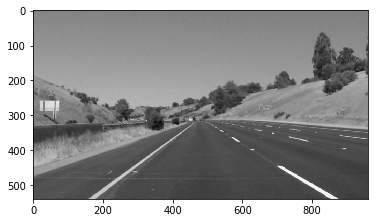

In [212]:
image = mpimg.imread('test_images/solidYellowCurve2.jpg')
gray = grayscale(image)
print("Image Shape: ", image.shape)
plt.imshow(gray, cmap='gray')

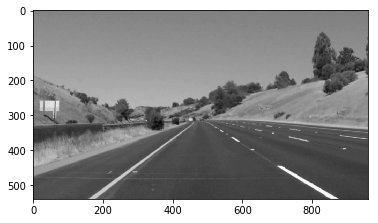

In [213]:
blurred = gaussian_blur(gray, GAUSSIAN_KERNEL)
plt.imshow(blurred, cmap='gray')

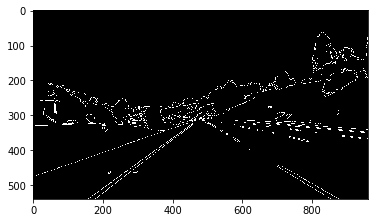

In [214]:
edges = canny(blurred, CANNY_HIGH, CANNY_LOW)
plt.imshow(edges, cmap='gray')

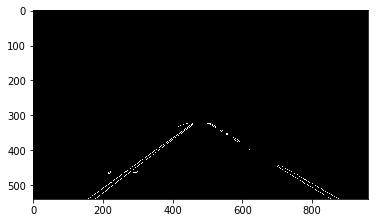

In [215]:
verts = roi_vertices(edges, ROI_TOP_LEFT, ROI_TOP_RIGHT, ROI_BOTTOM_LEFT, ROI_BOTTOM_RIGHT,ROI_TOP, ROI_BOTTOM)
roi = region_of_interest(edges, verts)
plt.imshow(roi, cmap='gray')

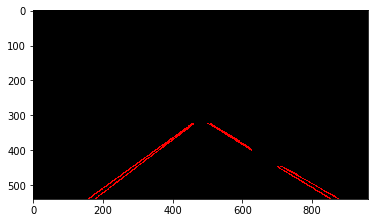

In [234]:
lines, hough_img = hough_lines(roi, HOUGH_RHO, HOUGH_THETA, HOUGH_THRESHOLD, HOUGH_MIN_LEN, HOUGH_MAX_GAP)
plt.imshow(hough_img, cmap='gray')

In [247]:
test_line = [[1,1,2,2]]
print("In: ", test_line, theta(test_line))
l, t = extendLine(test_line, 0, 5, 0, 4)
print("Out: ", l, t)
test_line = [[2,2,1,3]]
print("In: ", test_line, theta(test_line))
l, t = extendLine(test_line, 0, 5, 0, 4)
print("Out: ", l, t)

In:  [[1, 1, 2, 2]] 0.7853981633974483
Out:  [[0, 0, 4, 4]] 0.7853981633974483
In:  [[2, 2, 1, 3]] 2.356194490192345
Out:  [[4, 0, 0, 4]] 2.356194490192345


[[[-97, 0, 879, 540]]] [[[157, 540, 904, 0]]]
hough_img.shage:  (540, 960, 3)
bounds: 


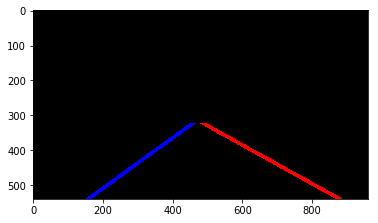

In [248]:
p,n,pt,nt = sloped_lines(lines,
                            min_theta_pos=THETA_POS_THRESHOLD,
                            min_theta_neg=THETA_NEG_THRESHOLD,
                            average=False, minY=0, maxY=hough_img.shape[0],
                            minX=0, maxX=hough_img.shape[1],
                            findEndPoints=True, useLongest=True)
print(p, n)
slope_img = np.zeros((hough_img.shape[0], hough_img.shape[1], 3), dtype=np.uint8)
draw_lines(slope_img, p, color=[255, 0, 0], thickness=10)
draw_lines(slope_img, n, color=[0, 0, 255], thickness=10)
clipped_lanes = region_of_interest(slope_img, verts)
print("hough_img.shage: ", hough_img.shape)
print("bounds: ", )
plt.imshow(clipped_lanes, cmap='gray')

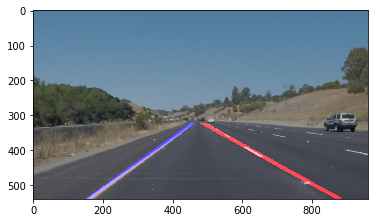

In [249]:
slopeFiltered = weighted_img(clipped_lanes, image, α=0.8, β=1., γ=0.)
plt.imshow(slopeFiltered)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [250]:
import os
os.listdir("test_images/")

['solidWhiteRight.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowCurve.jpg']

In [251]:
os.listdir("test_images_output/")

['solidWhiteRight.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowCurve.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

Original image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


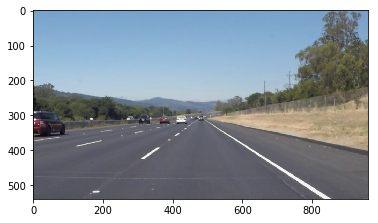

In [252]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

def image_pipeline(initial_image, outFileName=None, thickness=6, includeHough=False):
    #Grayscale
    gray = grayscale(initial_image)
    
    #Canny
    edges = canny(gaussian_blur(gray, GAUSSIAN_KERNEL), CANNY_LOW, CANNY_HIGH)

    #Region of Interest
    verts = roi_vertices(edges, ROI_TOP_LEFT, ROI_TOP_RIGHT, ROI_BOTTOM_LEFT, ROI_BOTTOM_RIGHT,ROI_TOP, ROI_BOTTOM)
    roi = region_of_interest(edges, verts)
    
    #Hough
    lines, hough_img = hough_lines(roi, HOUGH_RHO, HOUGH_THETA, HOUGH_THRESHOLD, HOUGH_MIN_LEN, HOUGH_MAX_GAP)
    
    #Slopes - filter lines based on their slopes, dividing them into positive and negative lists
    width, depth = hough_img.shape[1], hough_img.shape[0]
    pos, neg, pt, nt = sloped_lines(lines,
                            min_theta_pos=THETA_POS_THRESHOLD,
                            min_theta_neg=THETA_NEG_THRESHOLD,
                            average=False, minY=0, maxY=depth, minX=0, maxX=width,
                            findEndPoints=True, useLongest=True)

    slope_img = np.zeros((hough_img.shape[0], hough_img.shape[1], 3), dtype=np.uint8)
    draw_lines(slope_img, pos, color=[255, 0, 0], thickness=thickness)
    draw_lines(slope_img, neg, color=[255, 0, 0], thickness=thickness)
    clipped_lanes = region_of_interest(slope_img, verts)
    
    #Overlay lane lines on original image
    #lanes = np.zeros((initial_image.shape[0], initial_image.shape[1], 3), dtype=np.uint8)
    #draw_lines(lanes, lines, color=[255, 0, 0], thickness=2)
    #final_image = weighted_img(lanes, initial_image)
    highlightedLanes = weighted_img(clipped_lanes, initial_image, α=0.8, β=1., γ=0.)
    
    #write final image to image file
    if outFileName != None:
        mpimg.imsave(outFileName, highlightedLanes, format='jpg')
    
    if includeHough == True:
        return highlightedLanes, hough_img
    else:
        return highlightedLanes

#reading in an image
image_source = 'test_images/solidWhiteRight.jpg'
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('Original image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)

## Use The Lane Finding Pipeline



Use the pipeline to run the solution on all test_images. Make copies into the `test_images_output`.

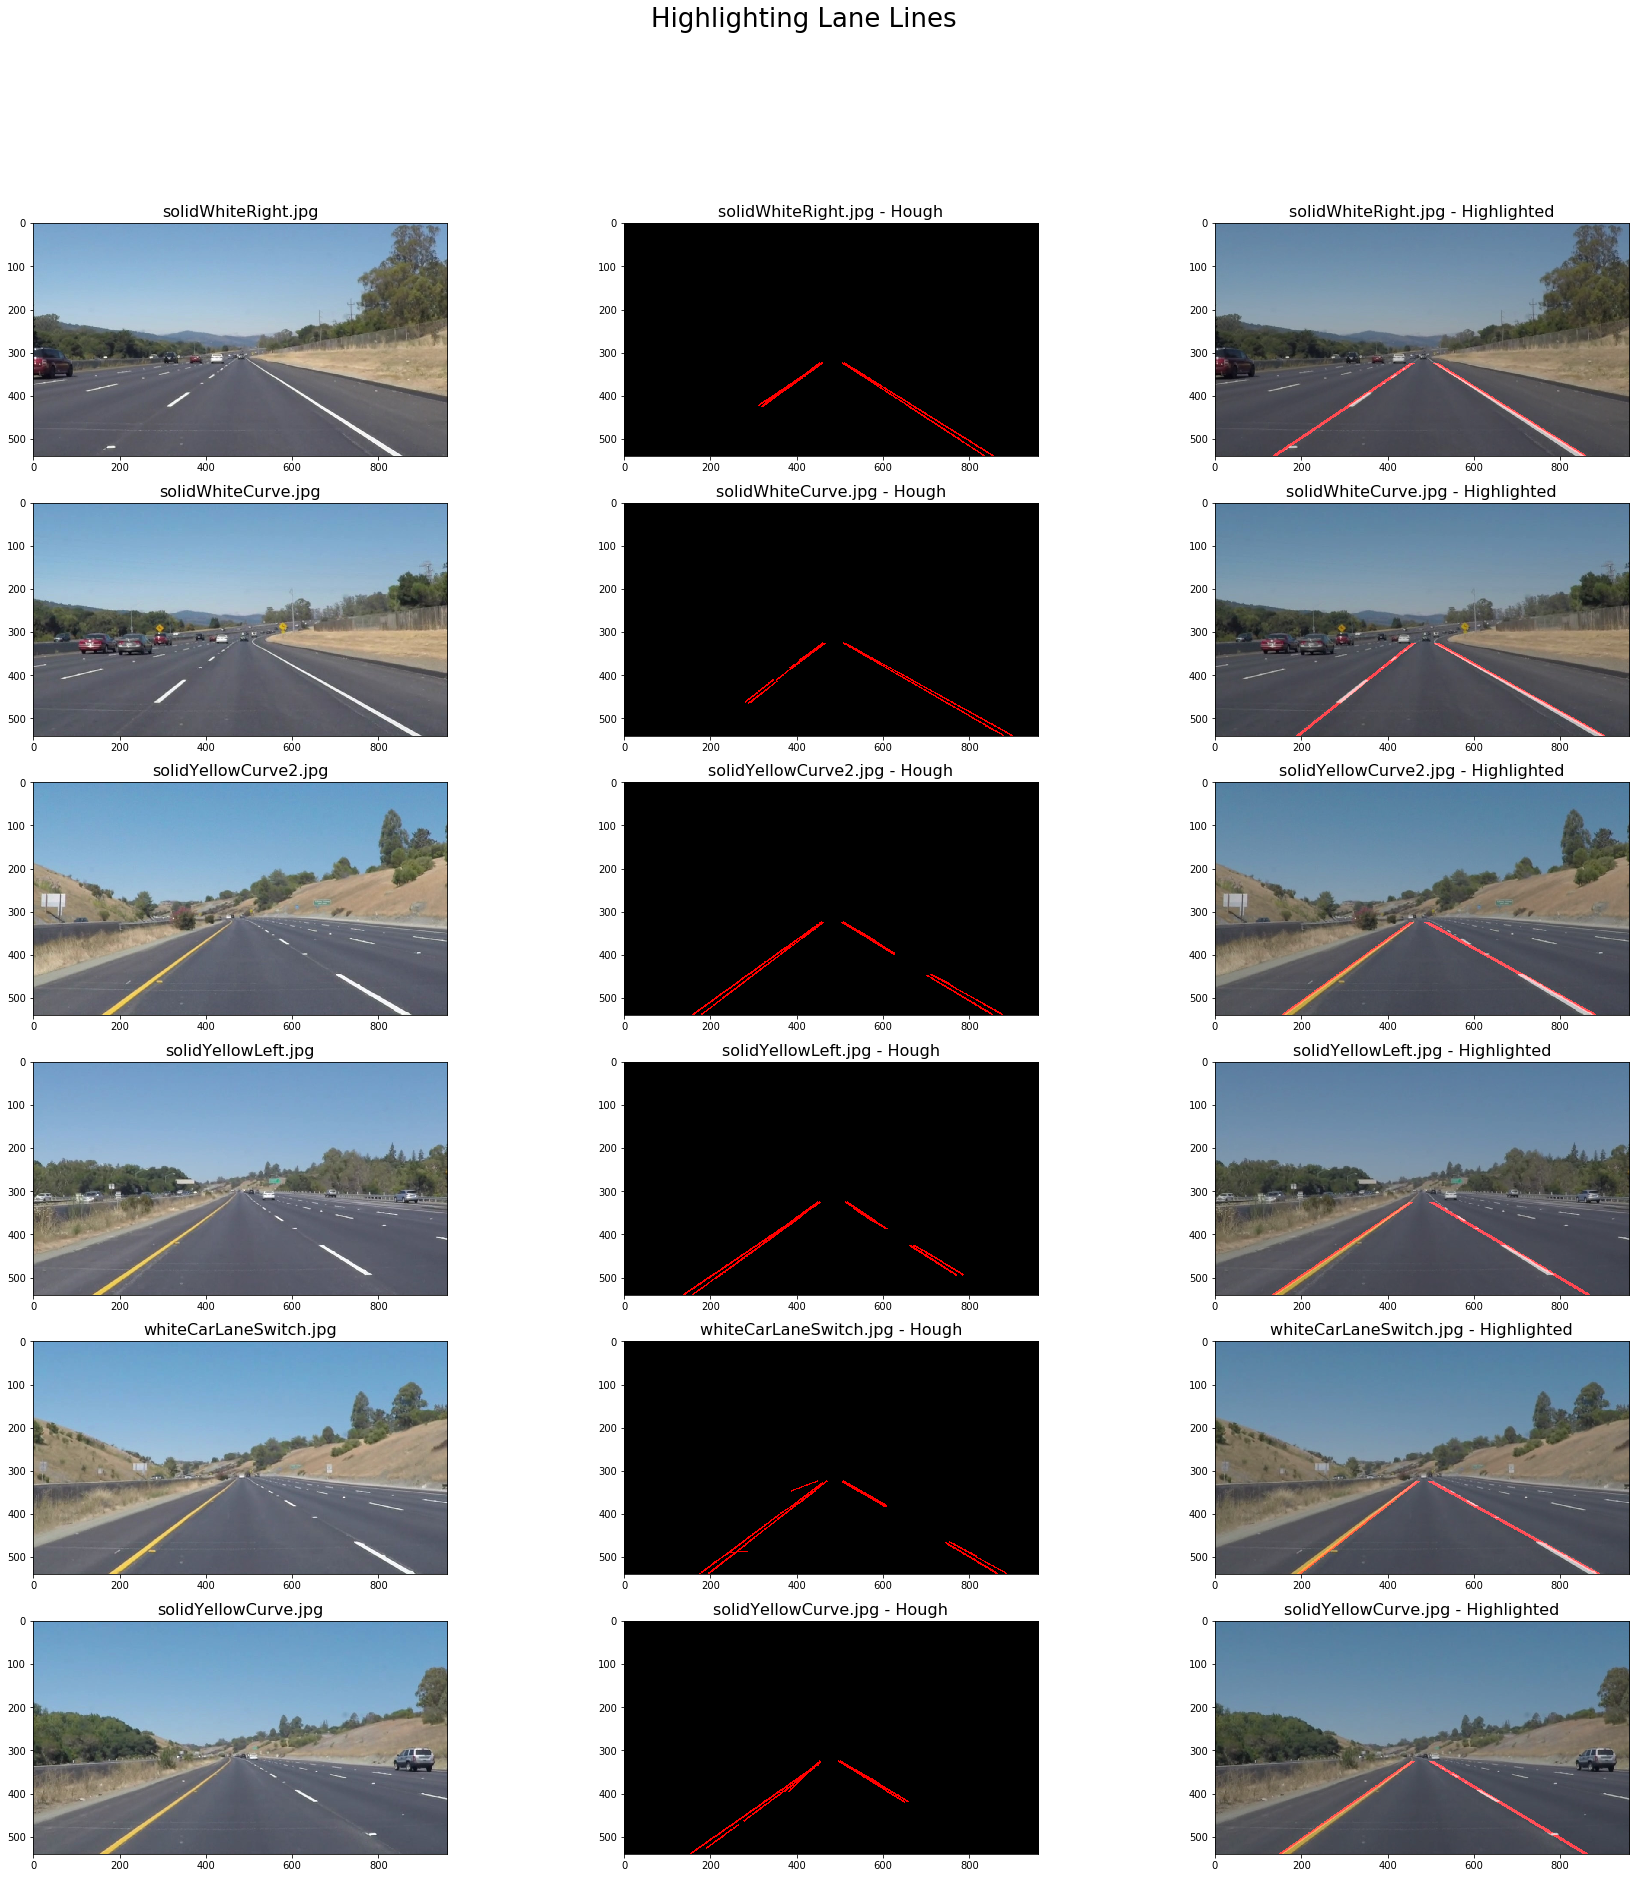

In [253]:
inDir = "test_images/"
outDir = "test_images_output/"

image_file_list = os.listdir(inDir)

#create a multi-plot figure
nRows, nCols = len(image_file_list), 3
fig = plt.figure(figsize=(30, 30))
fig.tight_layout()
fig.suptitle('Highlighting Lane Lines', fontsize=26)

for i in range(len(image_file_list)):
    fname = image_file_list[i]
    output_file = os.path.join(outDir, fname)
    image = mpimg.imread(inDir +fname)
    highlightedLanes, hough_img = image_pipeline(image, outFileName=output_file, thickness=6, includeHough=True)

    # Add original image to the plot
    a = fig.add_subplot(nRows, nCols, i * nCols + 1)
    imgplot = plt.imshow(image)
    a.set_title(fname, fontsize=16)
    
    # Add hough image to the plot
    a = fig.add_subplot(nRows, nCols, i *nCols + 2)
    imgplot = plt.imshow(hough_img)
    a.set_title(fname + " - Hough", fontsize=16)
    
    # Add highlighted image to the plot
    a = fig.add_subplot(nRows, nCols, i * nCols + 3)
    imgplot = plt.imshow(highlightedLanes)
    a.set_title(fname + " - Highlighted", fontsize=16)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [224]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [225]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    highlightedLanes = image_pipeline(image, thickness=6)
    
    # you should return the final output (image where lines are drawn on lanes
    return highlightedLanes

Let's try the one with the solid white lane on the right first ...

In [228]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(1,4)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:13<00:00, 16.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.02 s, sys: 165 ms, total: 3.18 s
Wall time: 15.3 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [229]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [230]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:46<00:00, 14.67it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 9.36 s, sys: 629 ms, total: 9.99 s
Wall time: 48.2 s


In [231]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [232]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:34<00:00,  7.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 6.99 s, sys: 353 ms, total: 7.35 s
Wall time: 38.1 s


In [233]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))